<a href="https://colab.research.google.com/github/tharushaliyanagama/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-I/Text_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Data Preprocessing**

**Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle
import shap


**Load and Inspect the Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/DSGP/Siyumi/DatasetNew.csv')

In [4]:
#Display information
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   public_id             2237 non-null   int64  
 1   lesion_id             2237 non-null   int64  
 2   patient_id            2237 non-null   int64  
 3   localization          2237 non-null   object 
 4   larger_size           2237 non-null   float64
 5   tobacco_use           2237 non-null   object 
 6   alcohol_consumption   2237 non-null   object 
 7   sun_exposure          2237 non-null   object 
 8   gender                2237 non-null   object 
 9   skin_color            2237 non-null   object 
 10  age_group             2237 non-null   int64  
 11  cancer_or_non_cancer  2237 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 209.8+ KB
None


In [5]:
#Load 5 rows
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
   public_id  lesion_id  patient_id localization  larger_size tobacco_use  \
0          0         50          48       Tongue          2.0         Yes   
1          1         50          48       Tongue          2.0         Yes   
2          2         41          39       Tongue          2.5         Yes   
3          3         41          39       Tongue          2.5         Yes   
4          4         87          81          Lip          1.5      Former   

  alcohol_consumption sun_exposure gender skin_color  age_group  \
0                  No           No      M      Black          2   
1                  No           No      M      Black          2   
2              Former          Yes      M      White          0   
3              Former          Yes      M      White          0   
4                 Yes          Yes      F      White          0   

  cancer_or_non_cancer  
0               Cancer  
1               Cancer  
2               Cancer  
3               Can

In [6]:
# Select numeric variables
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

# Print numeric variables
print("Numeric Variables:")
print(numeric_columns.head())

Numeric Variables:
   public_id  lesion_id  patient_id  larger_size  age_group
0          0         50          48          2.0          2
1          1         50          48          2.0          2
2          2         41          39          2.5          0
3          3         41          39          2.5          0
4          4         87          81          1.5          0


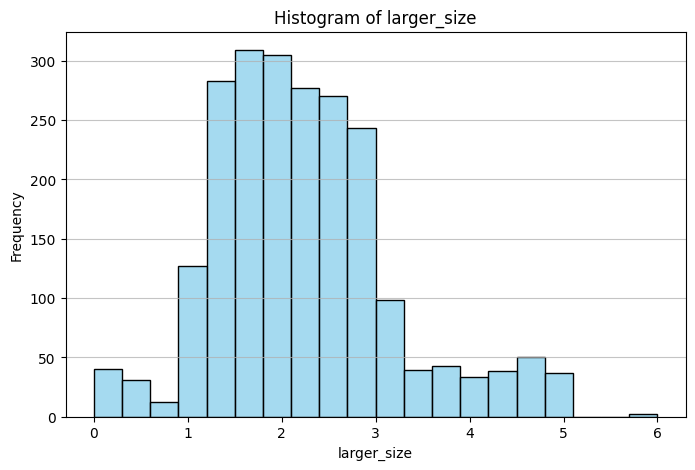

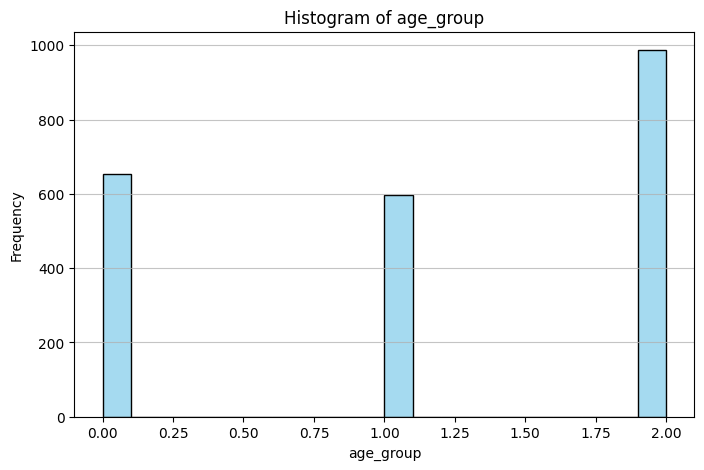

In [7]:
# Plot histograms for specific numerical variables
for column in ['larger_size', 'age_group']:
    if column in data.select_dtypes(include=['number']).columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(data, x=column, bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.grid(axis='y', alpha=0.75)
        plt.show()


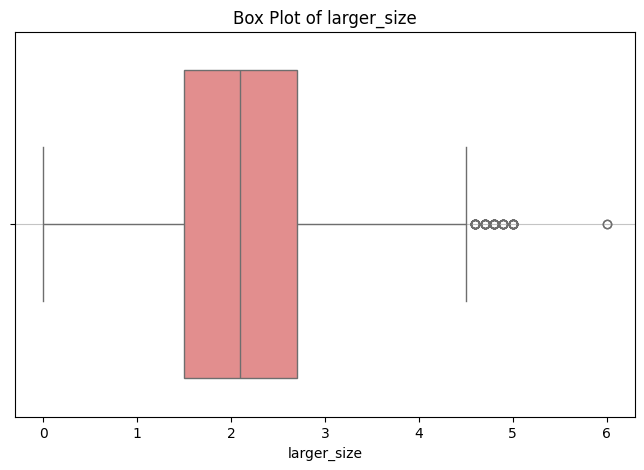

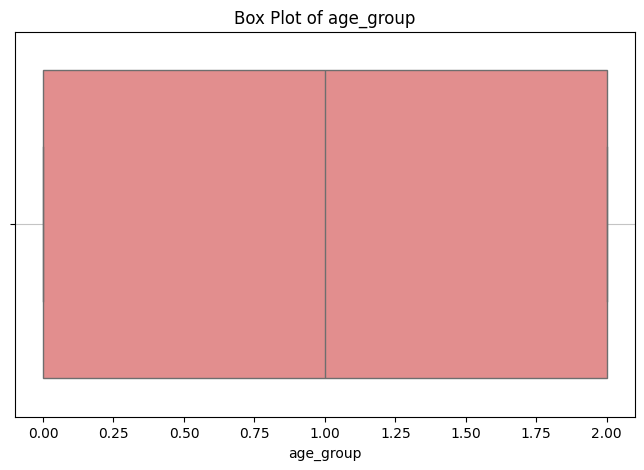

In [8]:
# Plot box plots for specific numerical variables to identify outliers
for column in ['larger_size', 'age_group']:
    if column in data.select_dtypes(include=['number']).columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=data, x=column, color='lightcoral')
        plt.title(f"Box Plot of {column}")
        plt.xlabel(column)
        plt.grid(axis='y', alpha=0.75)
        plt.show()

In [9]:
# Calculate the IQR for the 'larger_size' column
Q1 = data['larger_size'].quantile(0.25)  # 25th percentile
Q3 = data['larger_size'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to exclude outliers
filtered_data = data[(data['larger_size'] >= lower_bound) & (data['larger_size'] <= upper_bound)]

# Display the number of rows removed
removed_rows = len(data) - len(filtered_data)
print(f"Number of rows removed: {removed_rows}")

Number of rows removed: 67


In [10]:
# Select categorical variables
categorical_columns = data.select_dtypes(include=['object'])

# Print categorical variables
print("Categorical Variables:")
print(categorical_columns.head())

Categorical Variables:
  localization tobacco_use alcohol_consumption sun_exposure gender skin_color  \
0       Tongue         Yes                  No           No      M      Black   
1       Tongue         Yes                  No           No      M      Black   
2       Tongue         Yes              Former          Yes      M      White   
3       Tongue         Yes              Former          Yes      M      White   
4          Lip      Former                 Yes          Yes      F      White   

  cancer_or_non_cancer  
0               Cancer  
1               Cancer  
2               Cancer  
3               Cancer  
4               Cancer  


In [11]:
# Print unique values for each column
print("Unique Values in Each Column:")
for column in data.columns:
    unique_values = data[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print("----")

Unique Values in Each Column:
Column: public_id
Unique Values: [   0    1    2 ... 2234 2235 2236]
----
Column: lesion_id
Unique Values: [ 50  41  87 103 101  54 129  11  22  68  58  77 102  33  96  84 106  53
  88 130  15  64 104  24  73  31  30  42   6  27  78  18  83  74  95  62
  56  59   1  47  45  85  67  23 107  80  94  90   0  32  51  12  36  86
  72  89  26  91  57  38  70  75 131  52  20  98  37 123 124 190 191 192
 193 194 195 215 216  93  49  55  40  65  66  97  44  76  34  43  99  81
  61  79  60  39  35  69  48  82  63  46  71  92   5  16  29  14  25   8
  13   2  28   7  19   4  10 100   3   9  17  21]
----
Column: patient_id
Unique Values: [ 48  39  81  78  14  52  24  10  20  63  55  71  31  90  51  82  13  60
  22  67  28  27  40   6  25  72  16  77  68  89  58  53  56   1  45  43
  79  62  21  29  74  88  84   0  30  49  11  34  80  66  83  85  54  36
  65  69  12  50  18  92  35 108 160 161 162 163 164 165 183  38  37  47
  32  46  59  57  26  44  41  42  23  33  70

In [12]:
# Check for missing values
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
public_id               0
lesion_id               0
patient_id              0
localization            0
larger_size             0
tobacco_use             0
alcohol_consumption     0
sun_exposure            0
gender                  0
skin_color              0
age_group               0
cancer_or_non_cancer    0
dtype: int64


In [13]:
# Check for duplicate rows
print(f"\nNumber of duplicate rows before removal: {data.duplicated().sum()}")


Number of duplicate rows before removal: 0


In [14]:
# Encode categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if column != 'cancer_or_non_cancer':
        print(f"Column: {column}")
        print(f"Unique values before encoding: {data[column].unique()}")

        # Apply LabelEncoder
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

        print(f"Unique values after encoding: {data[column].unique()}")
        print("-")

Column: localization
Unique values before encoding: ['Tongue' 'Lip' 'Floor of mouth' 'Buccal mucosa' 'Palate' 'Gingiva'
 'Cheek' 'Gum' 'Buccal Mucosa']
Unique values after encoding: [8 6 3 1 7 4 2 5 0]
-
Column: tobacco_use
Unique values before encoding: ['Yes' 'Former' 'No' 'Not informed']
Unique values after encoding: [3 0 1 2]
-
Column: alcohol_consumption
Unique values before encoding: ['No' 'Former' 'Yes' 'Not informed']
Unique values after encoding: [1 0 3 2]
-
Column: sun_exposure
Unique values before encoding: ['No' 'Yes' 'Not informed']
Unique values after encoding: [0 2 1]
-
Column: gender
Unique values before encoding: ['M' 'F']
Unique values after encoding: [1 0]
-
Column: skin_color
Unique values before encoding: ['Black' 'White' 'Not informed' 'Brown' 'Asian' 'Hispanic']
Unique values after encoding: [1 5 4 2 0 3]
-


In [15]:
# Map target variable to binary
data['cancer_or_non_cancer'] = data['cancer_or_non_cancer'].map({'Cancer': 1, 'Non-Cancer': 0})

In [16]:
#Analyze Target Imbalance
target_column = 'cancer_or_non_cancer'
print("\nTarget value distribution:")
print(data[target_column].value_counts())



Target value distribution:
cancer_or_non_cancer
0    1633
1     604
Name: count, dtype: int64


<Axes: xlabel='cancer_or_non_cancer'>

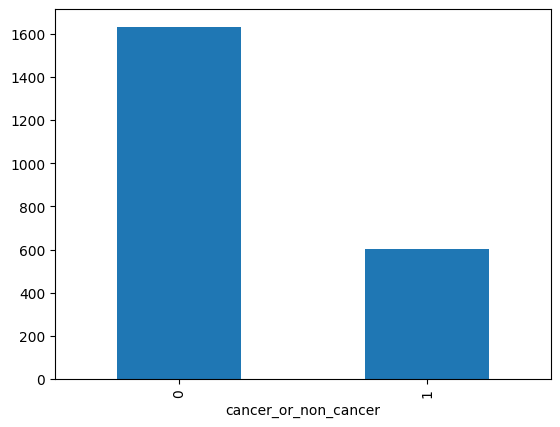

In [17]:
data[target_column].value_counts().plot(kind='bar')

In [18]:
# Handle class imbalance using SMOTE
X = data.drop(columns=[target_column])
y = data[target_column]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
cancer_or_non_cancer
1    1633
0    1633
Name: count, dtype: int64


<Axes: xlabel='cancer_or_non_cancer'>

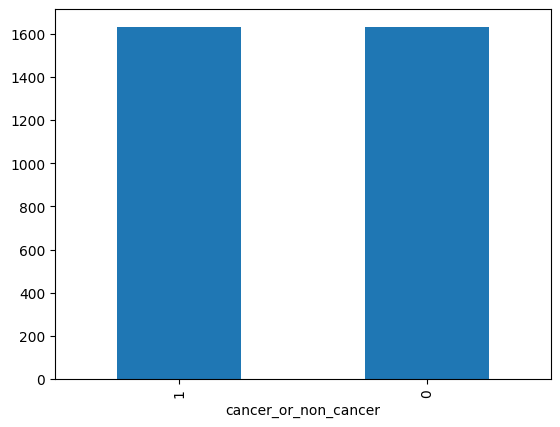

In [19]:
 pd.Series(y_resampled).value_counts().plot(kind='bar')

**Correlation Analysis**

In [20]:
print("\nCorrelation Analysis:")
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['cancer_or_non_cancer'].sort_values(ascending=False)
print(correlation_with_target)


Correlation Analysis:
cancer_or_non_cancer    1.000000
localization            0.068836
skin_color              0.017312
gender                  0.014332
age_group               0.012920
sun_exposure            0.009561
alcohol_consumption     0.008785
tobacco_use            -0.005747
larger_size            -0.010883
lesion_id              -0.016488
patient_id             -0.043370
public_id              -0.174845
Name: cancer_or_non_cancer, dtype: float64


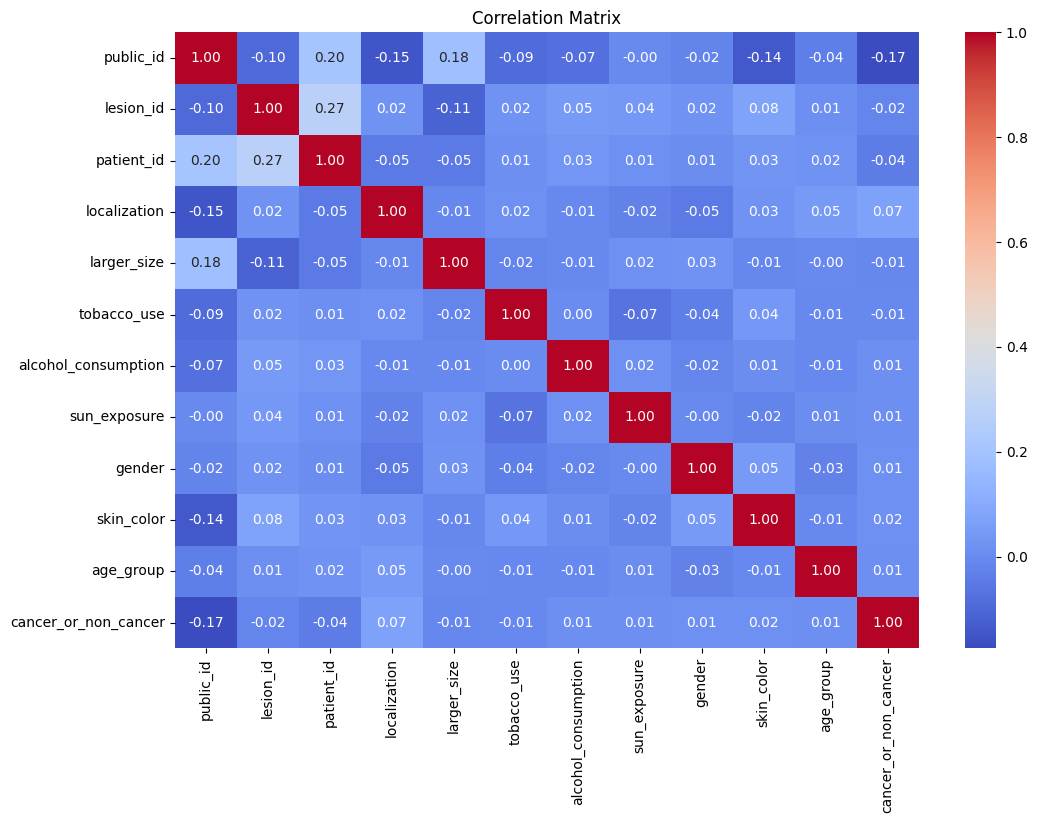

In [21]:
# Visualize correlation with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [22]:
#Feature Selection and Correlation Analysis
# Remove unnecessary features based on correlation and domain knowledge
columns_to_drop = ['patient_id', 'public_id', 'lesion_id']  # Irrelevant for prediction
print(f"\nDropping columns: {columns_to_drop}")
data = data.drop(columns=columns_to_drop)


Dropping columns: ['patient_id', 'public_id', 'lesion_id']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 2286
Test set size: 980


In [24]:
# Standard Scaling
# Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
print("\nNumerical columns:", numerical_cols)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])


Numerical columns: Index(['public_id', 'lesion_id', 'patient_id', 'localization', 'larger_size',
       'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender',
       'skin_color', 'age_group'],
      dtype='object')


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import pickle

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],        # Regularization parameter
    'kernel': ['linear', 'rbf'], # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf'
}

# Perform GridSearchCV for SVM
svm_model = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print("\nBest Parameters for SVM:", best_params)

# Train the SVM model with the best parameters
svm_model_best = grid_search.best_estimator_

# Evaluate the tuned SVM Model on Test Data
y_pred = svm_model_best.predict(X_test_scaled)
y_prob = svm_model_best.predict_proba(X_test_scaled)[:, 1]

# Print classification report and ROC-AUC score for the test data
print("\nTuned SVM Classification Report on Test Data:")
print(classification_report(y_test, y_pred))
print(f"Tuned SVM ROC-AUC Score on Test Data: {roc_auc_score(y_test, y_prob):.2f}")

# Evaluate the tuned SVM Model on Training Data (Optional for Overfitting Check)
y_train_pred = svm_model_best.predict(X_train_scaled)
y_train_prob = svm_model_best.predict_proba(X_train_scaled)[:, 1]

# Print classification report and ROC-AUC score for the training data
print("\nTuned SVM Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred))
print(f"Tuned SVM ROC-AUC Score on Training Data: {roc_auc_score(y_train, y_train_prob):.2f}")

# Save the trained tuned SVM model
with open('svm_model_tuned.pkl', 'wb') as file:
    pickle.dump(svm_model_best, file)

print("\nTuned SVM model saved as 'svm_model_tuned.pkl'.")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Tuned SVM Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       477
           1       0.72      0.77      0.74       503

    accuracy                           0.72       980
   macro avg       0.72      0.72      0.72       980
weighted avg       0.72      0.72      0.72       980

Tuned SVM ROC-AUC Score on Test Data: 0.79

Tuned SVM Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1156
           1       0.89      0.92      0.90      1130

    accuracy                           0.90      2286
   macro avg       0.90      0.90      0.90      2286
weighted avg       0.90      0.90      0.90      2286

Tuned SVM ROC-AUC Score on Training Data: 0.96

Tuned SVM model saved as 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import pickle

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimization algorithms
    'learning_rate': ['constant', 'adaptive'],  # Learning rate strategies
    'max_iter': [200, 300, 500]  # Maximum number of iterations
}

# Perform GridSearchCV for MLP Classifier
nn_model = MLPClassifier(random_state=42)
grid_search_nn = GridSearchCV(estimator=nn_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_nn.fit(X_train_scaled, y_train)

# Best parameters from grid search
best_params_nn = grid_search_nn.best_params_
print("\nBest Parameters for Neural Network:", best_params_nn)

# Train the Neural Network model with the best parameters
nn_model_best = grid_search_nn.best_estimator_

# Evaluate Neural Network Model on Test Data
y_pred_nn = nn_model_best.predict(X_test_scaled)
y_prob_nn = nn_model_best.predict_proba(X_test_scaled)[:, 1]

# Print classification report and ROC-AUC score for the test data
print("\nTuned Neural Network Classification Report on Test Data:")
print(classification_report(y_test, y_pred_nn))
print(f"Tuned Neural Network ROC-AUC Score on Test Data: {roc_auc_score(y_test, y_prob_nn):.2f}")

# Evaluate Neural Network Model on Training Data (Optional to check for overfitting)
y_train_pred_nn = nn_model_best.predict(X_train_scaled)
y_train_prob_nn = nn_model_best.predict_proba(X_train_scaled)[:, 1]

print("\nTuned Neural Network Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_nn))
print(f"Tuned Neural Network ROC-AUC Score on Training Data: {roc_auc_score(y_train, y_train_prob_nn):.2f}")

# Save the trained tuned Neural Network model
with open('nn_model_tuned.pkl', 'wb') as file:
    pickle.dump(nn_model_best, file)

print("\nTuned Neural Network model saved as 'nn_model_tuned.pkl'.")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
